<a href="https://www.kaggle.com/code/arunachal/churn-tuning-neuralnet-hyperparameters-on-pytorch?scriptVersionId=145663476" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

We explore viewer churn on a streaming platform using neural nets on Pytorch. We undertake the following steps:  

> 1. Predict total subscription days using Linear Regression as a baseline, and evaluate.
> 2. Predict churn using a default neural net, and evaluate.
> 3. Address target class imbalance using SMOTE re-sampling, and re-evaluate churn predictions.
> 4. Attempt improvements in model by introducing 
> > Drop-out layers  
> > Regularization  
> > Early Stopping   
> 5. Save a checkpoint for regularized model after training for a specified number of epochs
> 6. Re-load the checkpoint of the saved model and re-evaluate churn predictions.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, r2_score

import torch
from torch import nn, optim, Tensor
from torch.autograd import Variable
import torch.utils.data as Data

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
df = pd.read_csv('../input/customer-churn/data.csv')
df.head()

,year,customer_id,phone_no,gender,age,no_of_days_subscribed,multi_screen,mail_subscribed,weekly_mins_watched,minimum_daily_mins,maximum_daily_mins,weekly_max_night_mins,videos_watched,maximum_days_inactive,customer_support_calls,churn
0,2015,100198,409-8743,Female,36,62,no,no,148.35,12.2,16.81,82,1,4.0,1,0.0
1,2015,100643,340-5930,Female,39,149,no,no,294.45,7.7,33.37,87,3,3.0,2,0.0
2,2015,100756,372-3750,Female,65,126,no,no,87.30,11.9,9.89,91,1,4.0,5,1.0
3,2015,101595,331-4902,Female,24,131,no,yes,321.30,9.5,36.41,102,4,3.0,3,0.0
4,2015,101653,351-8398,Female,40,191,no,no,243.00,10.9,27.54,83,7,3.0,1,0.0


In [3]:
# Dropping columns with too many unique or insignificant values

df = df.drop(['customer_id', 'phone_no', 'year'], axis=1)

In [4]:
df.isnull().sum()

gender                    24
age                        0
no_of_days_subscribed      0
multi_screen               0
mail_subscribed            0
weekly_mins_watched        0
minimum_daily_mins         0
maximum_daily_mins         0
weekly_max_night_mins      0
videos_watched             0
maximum_days_inactive     28
customer_support_calls     0
churn                     35
dtype: int64

In [5]:
# Dropping all null rows

df.dropna(axis=0, inplace=True)

In [6]:
# Separating categorical columns for Label Encoding, numerical columns for MinMax Scaling

cats = ['gender', 'multi_screen', 'mail_subscribed']
nums = [col for col in df.columns if col not in cats]

In [7]:
# Label encoding categorical columns

le = LabelEncoder()

for cat in cats:
    
    df[cat] = le.fit_transform(df[cat])
    
df.head()

,gender,age,no_of_days_subscribed,multi_screen,mail_subscribed,weekly_mins_watched,minimum_daily_mins,maximum_daily_mins,weekly_max_night_mins,videos_watched,maximum_days_inactive,customer_support_calls,churn
0,0,36,62,0,0,148.35,12.2,16.81,82,1,4.0,1,0.0
1,0,39,149,0,0,294.45,7.7,33.37,87,3,3.0,2,0.0
2,0,65,126,0,0,87.30,11.9,9.89,91,1,4.0,5,1.0
3,0,24,131,0,1,321.30,9.5,36.41,102,4,3.0,3,0.0
4,0,40,191,0,0,243.00,10.9,27.54,83,7,3.0,1,0.0


<Axes: >

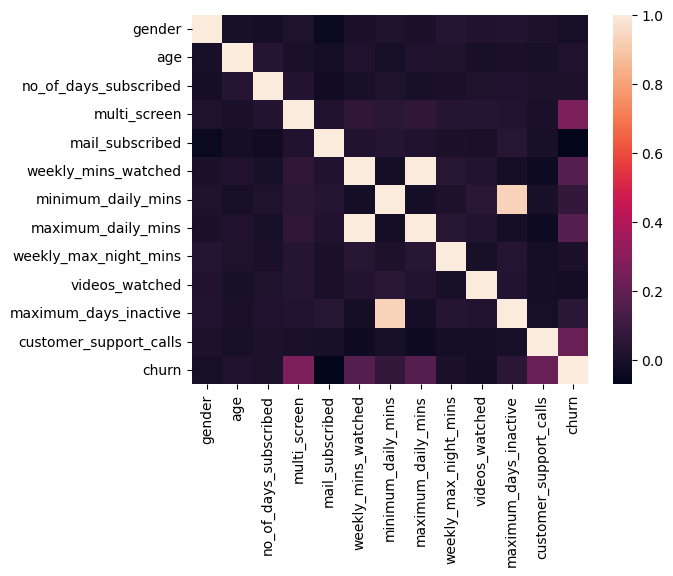

In [8]:
# Checking correlations of features with target label

sns.heatmap(df.corr())

In [9]:
df.groupby('churn').size()

churn
0.0    1665
1.0     253
dtype: int64

In [10]:
# MinMax Scaling numerical columns

scaler = MinMaxScaler()

df[nums] = scaler.fit_transform(df[nums])
df.head()

,gender,age,no_of_days_subscribed,multi_screen,mail_subscribed,weekly_mins_watched,minimum_daily_mins,maximum_daily_mins,weekly_max_night_mins,videos_watched,maximum_days_inactive,customer_support_calls,churn
0,0,0.281250,0.252066,0,0,0.281927,0.610,0.281858,0.300752,0.052632,0.666667,0.111111,0.0
1,0,0.328125,0.611570,0,0,0.559578,0.385,0.559524,0.338346,0.157895,0.500000,0.222222,0.0
2,0,0.734375,0.516529,0,0,0.165906,0.595,0.165828,0.368421,0.052632,0.666667,0.555556,1.0
3,0,0.093750,0.537190,0,1,0.610604,0.475,0.610496,0.451128,0.210526,0.500000,0.333333,0.0
4,0,0.343750,0.785124,0,0,0.461802,0.545,0.461771,0.308271,0.368421,0.500000,0.111111,0.0


In [11]:
# Separating feature and label vectors

y = df['no_of_days_subscribed']
X = df[[col for col in df.columns if col != 'no_of_days_subscribed']]

n_samples, n_features = X.shape

X = X.to_numpy()
y = y.to_numpy()

/opt/conda/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


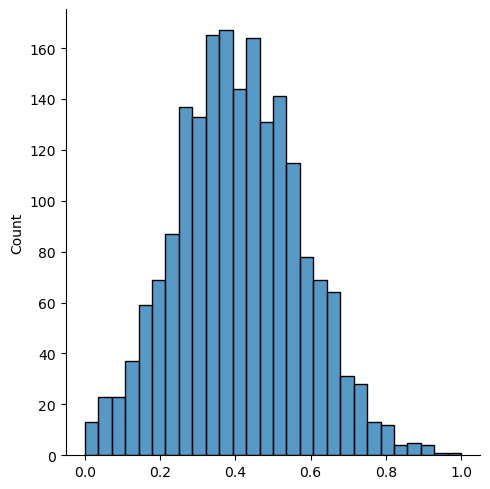

In [12]:
# Checking distribution of target labels

sns.displot(y)

Target labels approach a gaussian like distribution. We can expect the model to work fine.

In [13]:
# Splitting into train-test sets 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Converting test-train sets first to numpy floats and then to torch tensors

X_train = torch.from_numpy(X_train.astype(np.float32))
y_train = torch.from_numpy(y_train.astype(np.float32))
X_test = torch.from_numpy(X_test.astype(np.float32))
y_test = torch.from_numpy(y_test.astype(np.float32))

In [14]:
# Reshaping torch tensors for train and test sets

y_train = y_train.view(y_train.shape[0], 1)
y_test = y_test.view(y_test.shape[0], 1)

# Setting input and output dimensions

in_dim = n_features
out_dim = 1

We first build a baseline linear regression model.

In [15]:
# Creating class for the Linear Regression model

class LinearRegressor(torch.nn.Module):
    
    def __init__(self, in_dim, out_dim):
        
        super(LinearRegressor, self).__init__()
        self.model = torch.nn.Linear(in_dim, out_dim)
        
    def forward(self, x):
        
        y_pred = self.model(x)
        
        return y_pred       

In [16]:
# Setting model parameters

model = LinearRegressor(in_dim, out_dim)
epochs = 2500
lr = 0.1
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [17]:
# Training the model and relaying changes in loss

for epoch in range(epochs):
    
    y_pred = model(X_train)
    loss = criterion(y_pred, y_train)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    
    # Logging losses after every 100 epochs
    
    if (epoch+1)%100 == 0:
        
        print(f'epoch: {epoch+1}, loss= {loss.item():.4f}')

epoch: 100, loss= 0.0270
epoch: 200, loss= 0.0270
epoch: 300, loss= 0.0270
epoch: 400, loss= 0.0270
epoch: 500, loss= 0.0270
epoch: 600, loss= 0.0270
epoch: 700, loss= 0.0270
epoch: 800, loss= 0.0270
epoch: 900, loss= 0.0270
epoch: 1000, loss= 0.0270
epoch: 1100, loss= 0.0270
epoch: 1200, loss= 0.0276
epoch: 1300, loss= 0.0270
epoch: 1400, loss= 0.0270
epoch: 1500, loss= 0.0270
epoch: 1600, loss= 0.0270
epoch: 1700, loss= 0.0270
epoch: 1800, loss= 0.0270
epoch: 1900, loss= 0.0270
epoch: 2000, loss= 0.0270
epoch: 2100, loss= 0.0270
epoch: 2200, loss= 0.0270
epoch: 2300, loss= 0.0270
epoch: 2400, loss= 0.0270
epoch: 2500, loss= 0.0270


In [18]:
# Generating predictions for test data, detaching predictions from graph and converting to numpy array
# Generating R2 Score

y_pred = model(X_test).detach().numpy()
r2_score(y_test, y_pred)

-0.01749917724385952

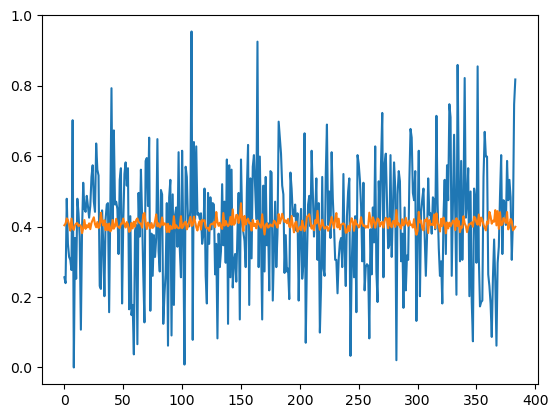

In [19]:
# Comparing predictions with test set

plt.plot(y_test)
plt.plot(y_pred)

The predictions are systematically low. Model hyperparameters need careful tuning.

We next build a simple neural network to predict the churn classes.

In [20]:
# Separating predictor and target columns

X = df.drop(['churn'], axis=1)
y = df['churn'].astype('int')

In [21]:
# Generating train-test sets

X_train, X_test, y_train, y_test = train_test_split(X.values, y, test_size=0.2, random_state=42)

In [22]:
# Generating data loader for training

batch_size = 64

X_train = Tensor(X_train)
y_train = Tensor(y_train)

data = Data.TensorDataset(X_train, y_train)
loader = Data.DataLoader(dataset=data, batch_size=batch_size, shuffle=True, num_workers=2)

In [23]:
# specifying parameters for model and training

input_size = X_train.shape[1]
hidden_sizes = [128, 64]
output_size = 2
criterion = nn.NLLLoss()
epochs = 100

In [24]:
# instancing model and building optimizer

model1 = nn.Sequential(nn.Linear(input_size, hidden_sizes[0]), nn.ReLU(), 
                      nn.Linear(hidden_sizes[0], hidden_sizes[1]), nn.ReLU(), 
                      nn.Linear(hidden_sizes[1], output_size), nn.Softmax(dim=1))

optimizer1 = optim.SGD(model1.parameters(), lr=0.01)

In [25]:
# Training default NN model

for e in range(epochs):
    
    running_loss = 0
    
    for step, (batch_x, batch_y) in enumerate(loader):
        
        b_x = Variable(batch_x)
        b_y = Variable(batch_y.type(torch.LongTensor))
        
        optimizer1.zero_grad()
        
        output = model1(b_x)
        loss = criterion(output, b_y)
        
        loss.backward()
        optimizer1.step()
        
        running_loss += loss.item()
        
    else:
        
        print(f'Training Loss: {running_loss/len(X_train)}')

Training Loss: -0.008219666788755216
Training Loss: -0.008889229892907273
Training Loss: -0.009532555529782173
Training Loss: -0.01016391912837072
Training Loss: -0.010767956639517394
Training Loss: -0.011319017006179034
Training Loss: -0.011791525483908523
Training Loss: -0.012174380183064487
Training Loss: -0.012470589389701555
Training Loss: -0.012695746051907694
Training Loss: -0.012866402270741071
Training Loss: -0.012995825908019303
Training Loss: -0.013094640073440533
Training Loss: -0.013170514454897565
Training Loss: -0.01323015962616872
Training Loss: -0.013280687695842678
Training Loss: -0.013319717314594573
Training Loss: -0.013350967283820857
Training Loss: -0.01337930284236525
Training Loss: -0.013401480666039975
Training Loss: -0.013421442743385942
Training Loss: -0.013438987335605447
Training Loss: -0.013452412524154942
Training Loss: -0.01346485291497182
Training Loss: -0.013475836411293358
Training Loss: -0.013486165227914883
Training Loss: -0.013494729218613527
Train

In [26]:
# Checking accuracy with test data set

X_test = Tensor(X_test)
y_test = Tensor(np.array(y_test))

z = model1(X_test)

y_pred = list(z.argmax(1))
y_test = list(y_test)

accuracy_score(y_test, y_pred)

0.859375

The accuracy score seems high but it can be misleading. The dataset appears imbalanced with respect to the target variable.

In [27]:
# Churn = 0 is over-represented in the sample

df.groupby('churn').size()

churn
0.0    1665
1.0     253
dtype: int64

In [28]:
from imblearn.over_sampling import SMOTE

In [29]:
smote = SMOTE()

In [30]:
# Resampling and balancing dataset using SMOTE

x_smote, y_smote = smote.fit_resample(df.iloc[:,:-1], df['churn'])

In [31]:
y_smote.value_counts()

0.0    1665
1.0    1665
Name: churn, dtype: int64

In [32]:
# Re-generating train-test sets with resampled data

X_train, X_test, y_train, y_test = train_test_split(x_smote, y_smote, test_size=0.2, 
                                                    random_state=42, stratify=y_smote)

In [33]:
# Checking if target classes are balanced

(y_train==0).sum(), (y_train==1).sum(), (y_test==0).sum(), (y_test==1).sum()

(1332, 1332, 333, 333)

We now implement multiple neural net models with this resampled dataset. First, we implement the default model above.

In [34]:
X_train = Tensor(X_train.values)
y_train = Tensor(np.array(y_train))

data = Data.TensorDataset(X_train, y_train)
loader = Data.DataLoader(dataset=data, batch_size=batch_size, shuffle=True, num_workers=2)

In [35]:
input_size = X_train.shape[1]
hidden_sizes = [128, 64]
output_size = 2

model2 = nn.Sequential(nn.Linear(input_size, hidden_sizes[0]), nn.ReLU(), 
                      nn.Linear(hidden_sizes[0], hidden_sizes[1]), nn.ReLU(), 
                      nn.Linear(hidden_sizes[1], output_size), nn.Softmax(dim=1))

optimizer2 = optim.SGD(model2.parameters(), lr=0.01)

In [36]:
for e in range(epochs):

    running_loss = 0

    for step, (batch_x, batch_y) in enumerate(loader):

        b_x = Variable(batch_x)
        b_y = Variable(batch_y.type(torch.LongTensor))

        optimizer2.zero_grad()

        output = model2(b_x)
        loss = criterion(output, b_y)

        loss.backward()
        optimizer2.step()

        running_loss += loss.item()

    else:

        print(f'Training Loss: {running_loss/len(X_train)}')

Training Loss: -0.007879049659849287
Training Loss: -0.007887519974339832
Training Loss: -0.00789511221665162
Training Loss: -0.007901959512774294
Training Loss: -0.00790862674201215
Training Loss: -0.007914206611591059
Training Loss: -0.00791985740711739
Training Loss: -0.00792664450568122
Training Loss: -0.007932897645968932
Training Loss: -0.007939277289507983
Training Loss: -0.007945540945630174
Training Loss: -0.007951994065765862
Training Loss: -0.007958541022943662
Training Loss: -0.007964912656549219
Training Loss: -0.007972125221301127
Training Loss: -0.007979149664486493
Training Loss: -0.007988075840401577
Training Loss: -0.00799590297736921
Training Loss: -0.00800322918025581
Training Loss: -0.008012854860530601
Training Loss: -0.008020843471492733
Training Loss: -0.00802858389757417
Training Loss: -0.008039077503366155
Training Loss: -0.008048042475998222
Training Loss: -0.008060432903401487
Training Loss: -0.008070184706567644
Training Loss: -0.008081197000301635
Training

In [37]:
X_test = Tensor(X_test.values)
y_test = Tensor(np.array(y_test))

z = model2(X_test)

y_pred = list(z.argmax(1))
y_test = list(y_test)

accuracy_score(y_test, y_pred)

0.7267267267267268

The accuracy score has decreased!

With the re-sampled data, we now add more hidden layers and introduce drop-out layers.

In [38]:
# Implementing model with drop-out layers

hidden_sizes = [128, 64, 32, 16]

model_dropout = nn.Sequential(nn.Linear(input_size, hidden_sizes[0]), nn.Dropout(0.2), nn.ReLU(), 
                              nn.Linear(hidden_sizes[0], hidden_sizes[1]), nn.Dropout(0.2), nn.ReLU(), 
                              nn.Linear(hidden_sizes[1], hidden_sizes[2]), nn.Dropout(0.2), nn.ReLU(), 
                              nn.Linear(hidden_sizes[2], output_size), nn.Dropout(0.2), nn.Softmax(dim=1))

optimizer_dropout = optim.SGD(model_dropout.parameters(), lr=0.01)

In [39]:
# Training on re-sampled data with drop-out layers

for e in range(epochs):

    running_loss = 0

    for step, (batch_x, batch_y) in enumerate(loader):

        b_x = Variable(batch_x)
        b_y = Variable(batch_y.type(torch.LongTensor))

        optimizer_dropout.zero_grad()

        output = model_dropout(b_x)
        loss = criterion(output, b_y)

        loss.backward()
        optimizer_dropout.step()

        running_loss += loss.item()

    else:

        print(f'Training Loss: {running_loss/len(X_train)}')

Training Loss: -0.007890959961099309
Training Loss: -0.007897965117796764
Training Loss: -0.007896523922681808
Training Loss: -0.007882498059276346
Training Loss: -0.00790518998831242
Training Loss: -0.007889307386524326
Training Loss: -0.007907388770991975
Training Loss: -0.007905220920527662
Training Loss: -0.007904544584564976
Training Loss: -0.007909129902317718
Training Loss: -0.007905231973340919
Training Loss: -0.00789851441352933
Training Loss: -0.007891311682201363
Training Loss: -0.00790632205145495
Training Loss: -0.00790537638707204
Training Loss: -0.007907454964813885
Training Loss: -0.007916975721672133
Training Loss: -0.007929792554976346
Training Loss: -0.007904749318912581
Training Loss: -0.007916691883637741
Training Loss: -0.00791339484510479
Training Loss: -0.007929928019061103
Training Loss: -0.007927550120396656
Training Loss: -0.00791485541620412
Training Loss: -0.00791584881576332
Training Loss: -0.007930190143016007
Training Loss: -0.007926854016902568
Training

In [40]:
# Checking test-set accuracy for model with dropouts trained on resampled dataset

X_test = Tensor(X_test)
y_test = Tensor(np.array(y_test))

z = model_dropout(X_test)

y_pred = list(z.argmax(1))
y_test = list(y_test)

accuracy_score(y_test, y_pred)

0.6771771771771772

The accuracy score has decreased further. The model hyperparameters need a more careful tuning.

We now implement a regularized model on the resampled dataset.

In [41]:
# Implementing model with regularization

hidden_sizes = [128, 64]

model_reg = nn.Sequential(nn.Linear(input_size, hidden_sizes[0]), nn.Dropout(0.2), nn.ReLU(), 
                      nn.Linear(hidden_sizes[0], hidden_sizes[1]), nn.Dropout(0.2), nn.ReLU(), 
                      nn.Linear(hidden_sizes[1], hidden_sizes[1]), nn.Dropout(0.1), nn.ReLU(), 
                      nn.Linear(hidden_sizes[1], output_size), nn.Softmax(dim=1))

optimizer_reg = optim.Adam(model_reg.parameters(), lr=1e-4, weight_decay=1e-5)

In [42]:
# Training on re-sampled data with regularised neural nets

for e in range(epochs):

    running_loss = 0

    for step, (batch_x, batch_y) in enumerate(loader):

        b_x = Variable(batch_x)
        b_y = Variable(batch_y.type(torch.LongTensor))

        optimizer_reg.zero_grad()

        output = model_reg(b_x)
        loss = criterion(output, b_y)

        loss.backward()
        optimizer_reg.step()

        running_loss += loss.item()

    else:

        print(f'Training Loss: {running_loss/len(X_train)}')

Training Loss: -0.00789115356432425
Training Loss: -0.007912019396329427
Training Loss: -0.00793682941579604
Training Loss: -0.007978849202483982
Training Loss: -0.008048165779750984
Training Loss: -0.008188841176462604
Training Loss: -0.008387796983525559
Training Loss: -0.008700560811940615
Training Loss: -0.009122924716980965
Training Loss: -0.009540988249821705
Training Loss: -0.00997347807562029
Training Loss: -0.010257849016705074
Training Loss: -0.01049635355715995
Training Loss: -0.01065839332592738
Training Loss: -0.010918574670592585
Training Loss: -0.011008995185206245
Training Loss: -0.011087811946331917
Training Loss: -0.011178903796293356
Training Loss: -0.011264301702245936
Training Loss: -0.011395527480600832
Training Loss: -0.011407158530510223
Training Loss: -0.011405657607692856
Training Loss: -0.011422348921900397
Training Loss: -0.011455922401524163
Training Loss: -0.011641161152729401
Training Loss: -0.011609601723897207
Training Loss: -0.011676561367046367
Traini

In [43]:
# Checking test-set accuracy for model with regularization trained on resampled dataset

X_test = Tensor(X_test)
y_test = Tensor(np.array(y_test))

z = model_reg(X_test)

y_pred = list(z.argmax(1))
y_test = list(y_test)

accuracy_score(y_test, y_pred)

0.8033033033033034

The acuuracy of model has improved with regularization. This time, the resampled dataset is also balanced.

We now introduce an early stopping feature on the resampled dataset.

In [44]:
# Implementing model with early stopping

model_es = nn.Sequential(nn.Linear(input_size, hidden_sizes[0]), nn.Dropout(0.2), nn.ReLU(), 
                      nn.Linear(hidden_sizes[0], hidden_sizes[1]), nn.Dropout(0.2), nn.ReLU(), 
                      nn.Linear(hidden_sizes[1], hidden_sizes[1]), nn.Dropout(0.1), nn.ReLU(), 
                      nn.Linear(hidden_sizes[1], output_size), nn.Softmax(dim=1))

optimizer_es = optim.Adam(model_es.parameters(), lr=1e-4, weight_decay=1e-5)

In [45]:
# Initializing early stopping thresholds

epochs_no_improve = 0
early_stop = False
min_loss = np.Inf
iter = 0

In [46]:
# Training on re-sampled data with neural nets with early stopping feature

for e in range(epochs):
    
    running_loss = 0
    
    if early_stop:
        
        print("Stopped")
        break
        
    else:
        
        for step, (batch_x, batch_y) in enumerate(loader):

            b_x = Variable(batch_x)
            b_y = Variable(batch_y.type(torch.LongTensor))

            optimizer_es.zero_grad()

            output = model_es(b_x)
            loss = criterion(output, b_y)
            loss.backward()
            optimizer_es.step()

            running_loss += loss.item()

            if abs(running_loss) < abs(min_loss):
                
                epochs_no_improve = 0
                min_loss = running_loss
                
            else:
                
                epochs_no_improve +=1
                
            iter += 1

            if e > 5 and epochs_no_improve == epochs:
                
                print('Early stopping!')
                early_stop = True
                
                break
            
            else:                
                continue

        else:
            print(f"Training loss: {running_loss/len(X_train)}")

Training loss: -0.007896224557010978
Training loss: -0.007915418315399159
Training loss: -0.00795132575092373
Training loss: -0.00799159238019863
Training loss: -0.008080472582363867
Training loss: -0.008236731181631575
Training loss: -0.008467107093906976
Training loss: -0.008811587551692585
Training loss: -0.00926433772117168
Training loss: -0.009629900391037399
Training loss: -0.009917523655984495
Training loss: -0.010128653980232216
Training loss: -0.010393051145313022
Training loss: -0.010553842527909321
Training loss: -0.010726384594812765
Training loss: -0.010785820986236538
Training loss: -0.010882012769803629
Training loss: -0.011037488465194588
Training loss: -0.011172539769887208
Training loss: -0.011156601657917549
Training loss: -0.011165983482703075
Training loss: -0.011303512854977054
Training loss: -0.011273461508679318
Training loss: -0.01138660801692052
Training loss: -0.01143332185956451
Training loss: -0.011429848568933504
Training loss: -0.01149135628888557
Trainin

In [47]:
# Checking test-set accuracy for model with early stopping feature trained on resampled dataset

X_test = Tensor(X_test)
y_test = Tensor(np.array(y_test))

z = model_es(X_test)

y_pred = list(z.argmax(1))
y_test = list(y_test)

accuracy_score(y_test, y_pred)

0.8018018018018018

The accuracy score has improved!

We now create a checkpoint after running the regularized model for 10 epochs, re-load the checkpoint, and evaluate predictions for the test set.

In [50]:
# Creating and loading checkpoint for the model with regularization

hidden_sizes = [128, 64]

model_chk = nn.Sequential(nn.Linear(input_size, hidden_sizes[0]), nn.Dropout(0.2), nn.ReLU(), 
                      nn.Linear(hidden_sizes[0], hidden_sizes[1]), nn.Dropout(0.2), nn.ReLU(), 
                      nn.Linear(hidden_sizes[1], hidden_sizes[1]), nn.Dropout(0.1), nn.ReLU(), 
                      nn.Linear(hidden_sizes[1], output_size), nn.Softmax(dim=1))

optimizer_chk = optim.Adam(model_chk.parameters(), lr=1e-4, weight_decay=1e-5)

In [56]:
# Creating a directory to save the model after a specified number of epochs

epochs = 10
!mkdir model
path = '/kaggle/working/model/'

mkdir: cannot create directory ‘model’: File exists


In [57]:
# Training regularized model for 10 epochs and creating a checkpoint

for e in range(epochs):

    running_loss = 0

    for step, (batch_x, batch_y) in enumerate(loader):

        b_x = Variable(batch_x)
        b_y = Variable(batch_y.type(torch.LongTensor))

        optimizer_chk.zero_grad()

        output = model_chk(b_x)
        loss = criterion(output, b_y)

        loss.backward()
        optimizer_chk.step()

        running_loss += loss.item()
        
        torch.save({'epoch': e,
                   'model_state': model_chk.state_dict,
                   'optimizer_state': optimizer_chk.state_dict,
                   'loss': running_loss}, path + 'model_' + str(e) + '.pt')

    else:

        print(f'Training Loss: {running_loss/len(X_train)}')

Training Loss: -0.007908270803389248
Training Loss: -0.007945026475209015
Training Loss: -0.007992763598043998
Training Loss: -0.0080881378202288
Training Loss: -0.00822782375522562
Training Loss: -0.008451069305250953
Training Loss: -0.008763827405892335
Training Loss: -0.00909347861289262
Training Loss: -0.009559413043407348
Training Loss: -0.009849476720298733


In [58]:
# Loading regularized model from the checkpoint

model_load = model_chk
optimizer_load = optimizer_chk

checkpoint = torch.load(path+'model_9.pt')
model_load.load_state_dict(checkpoint['model_state']())
optimizer_load.load_state_dict(checkpoint['optimizer_state']())
epoch = checkpoint['epoch']
loss = checkpoint['loss']

model_load.eval()

Sequential(
  (0): Linear(in_features=12, out_features=128, bias=True)
  (1): Dropout(p=0.2, inplace=False)
  (2): ReLU()
  (3): Linear(in_features=128, out_features=64, bias=True)
  (4): Dropout(p=0.2, inplace=False)
  (5): ReLU()
  (6): Linear(in_features=64, out_features=64, bias=True)
  (7): Dropout(p=0.1, inplace=False)
  (8): ReLU()
  (9): Linear(in_features=64, out_features=2, bias=True)
  (10): Softmax(dim=1)
)

In [59]:
# Evaluating predictions for test-set with the now re-loaded, saved model

X_test = Tensor(X_test)
y_test = Tensor(np.array(y_test))

z = model_load(X_test)

y_pred = list(z.argmax(1))
y_test = list(y_test)

accuracy_score(y_test, y_pred)

0.6951951951951952